# Multistep Bayesian Optimization for Level-Set Estimation over a Markov Random Field

## Summary:

* We extend our optimal multi-step algorithm for level-set estimation to a discrete Gaussian Markov Random field setting.
* We state (without proof) how our additive value-function decomposition manifests in this setting.
* Despite the value-function decompositing as a sum of single-grid values, we find that, in the most general case, the optimal algorithm cannot be computed efficiently, because the number of possible boundary value states grows exponentially in the size of the grid.
* We discuss two approaches to overcome this intractability:
    * One approach is to use a computationally tractable state-space approximation.
    * The other approach is to assume that the underlying graph is sparse, in the sense that any "slice" has at most a constant number of edges crossing it.
* We implement a dynamic-programming algorithm which leverages the value-function decomposition and the aforementioned state-space approximation to compute the (approximate) optimal value function.
    * The DP algorithm uses simulation to estimate state-transition probabilities, so as part of this implementation we include code to simulate observations of subsets of a GMRF.
    * (For simplicity of implementation) we consider a class of GMRFs where the precision matrix is given by a linear combination of the identity matrix and the graph-Laplacian matrix.  I didn't see this approach being used in a brief literature review so this might be of mild outside interest.
* We visualize the Q-values of different actions for various grid sizes and sampling costs and observe that the resulting values pass basic "sanity checks".
* Lots of followup work still to be done:
    * More detailed simulations.  E.g. How does the value of the (approximate) optimal policy compare to reasonable heuristics?
    * Implement the exact (up to discretization) algorithm for a GMRF over a sparse graph.
    
**Disclaimer**: Most of the code was written hastily in a day, and it can be quite cumbersome to read!  Especially the code in the util.py file.  Apologies for that.

## Introduction

In this notebook we extend the results of [our earlier paper](https://arxiv.org/abs/1607.03195) to a discrete Markov random field setting.

Following the [wikipedia article](https://en.wikipedia.org/wiki/Markov_random_field), a Markov random field (MRF) is a collection of random variables $(X_v : v\in V)$ indexed by a set of nodes $V$ of an undirected graph $G=(V,E)$ which satisfy the following properties:

* **Pairwise Markov property**: Any two random variables corresponding to non-adjacent vertices $u,v\in V$ are conditionally independent given all other variables: $$ X_u \perp X_v \mid X_{V\setminus\{u,v\}} $$
* **Local Markov property**: Any random variable is conditionally independent of all other variables conditioned on the random variables corresponding to its neighbours:
$$ X_v \perp X_{V\setminus N(v)} \mid X_{N(v)}$$
* **Global Markov property**: Any two subsets of vertices $A$, $B$, correspond to conditionally independent variables conditioned on a collection of variables which correspond to a separating set of vertices $S$:
$$ X_A \perp X_B \mid X_S $$
where any path from a node in $A$ to a node in $B$ must pass through a node in $S$.


## Problem Description

Let $(X_v)_{v\in V}$ be a MRF over a graph $G=(V,E)$.  Suppose the values of $(X_v)_{v\in V}$ are sampled at the beginning of time, after which our goal is to estimate the subset of nodes $U\subseteq V$ where the values $X_u$ exceed $0$.  However, before selecting this node, we have the ability to collect information about the values $(X_v)_{v\in V}$ by observing subsets of vertices.  

How do we compute the optimal adaptive policy for choosing which subsets of vertices to observe?

In the interest of concreteness and simplicity, for the remainder of this notebook we consider the following special case.
* The nodes in our graph correspond to the 2-dimensional $M\times N$ grid: 
$$V = \{(i,j) : 1\leq i\leq M, 1\leq j\leq N\}.$$
* The edges in our graph denote the standard neighbour relationship in the grid, i.e. $u$ and $v$ are neighbours iff their $L_1$ distance is $1$.
* The marginal distribution of each random variable $X_v$ is a standard normal distribution. 
* The precision matrix $Q=\Sigma^{-1}$ for the joint distribution of $(X_v)_{v\in V}$ is given by the weighted sum of the identity matrix $I$ and the adjacency matrix $A$: $Q=\alpha I + (1-\alpha) A$, and 
$$ (X_v)_{v\in V}\sim N(0, Q^{-1}).$$ This choice of precision matrix [guarantees](https://www.stat.washington.edu/peter/PASI/Lecture-GMRF.pdf) that $(X_v)_{v\in V}$ is a MRF.  (Update: It does not.  See below for more discussion).


With these simplifying assumptions let us now fill in the details about our adaptive sampling procedure.

* At time $t=1$ we can choose:
    * A row $1\leq i \leq M$ to observe, meaning we see all values $(X_v)_{v\in R_i}$ where $R_i = \{(i,j) : 1\leq j \leq N\}$.
    * A column $1\leq j \leq N$ to observe, meaning we see all values $(X_v)_{v\in C_j}$
    where $C_j = \{(i,j) 1\leq i \leq M\}$.
    * To not observe any row or column and instead produce our subset estimate U.
    
At an arbitrary time $t$, suppose we have not yet chosen to collect our reward. Instead of having a single grid to work with, let $S_1,\dots,S_{t-1}$ be the sequence of rows and columns we have observed, which partition our original grid into a collection of $t$ grids, say $K_1,\dots,K_t$.  We can choose to observe a row- or column-slice from any of these $t$ grids, or we can choose to not collect any more information and produce our subset estimate $U$.

We assume every choice to observe an additional slice $S_t$ incurs cost $c>0$.

The reward for our estimate $U$ is additive across nodes, with a reward of $1$ for each node we get right and $0$ for each node we get wrong.  If $U^*=\{v\in V : X_v \geq 0\}$ is the true set of nodes whose value exceeds $0$, the reward for our estimate $U$ is defined as
$$
R(U,U*) = \sum_{v\in V} 1\{v \in U\cap U^*\} + 1\{v\in U^c \cap U^{*c}\}.
$$

## Simulating a GMRF

Let us now discuss how we will simulate our GMRF, and also discuss some of the structure that will soon help us characterize the value function.

Write $X=(X_v)_{v\in V}$ and recall $X\sim N(0,\Sigma)$ where the precision matrix $Q=\Sigma^{-1}$ is zero for all non-adjacent pairs of vertices: $Q_{uv}=0$ if $uv\neq E$.

Next, consider the following identity, taken from the [appendix of GPML](http://www.gaussianprocess.org/gpml/chapters/RWA.pdf):

![Gaussian Identity](gaussian_identity.png "Gaussian Identity")



Consider what this says about the distribution of $X_U \mid X_{U^c}$, where $U$ is one of the two resulting grids after observing a slice of vertices $S$.  Equation (A.6) states the following:

$$
X_U \mid X_{U^c} \sim N(\mu_U - Q_{UU}^{-1} Q_{U U^c} (X_{U^c} - \mu_{U^c}), Q_{UU}^{-1}).
$$

Next, consider what $Q_{U U^c}$ means in the context of our Gaussian MRF.  Each element $Q_{U U^c}(u,v)$ takes the value $0$ or $\alpha$ and the only pairs $(u,v)$ for which it takes the value $\alpha$ must be neighbours in the underlying graph.  In particular, $Q_{U U^c}(u,v)$ is $0$ for every $v$ not contained in the slice $S$.

Thus, it follows that $X_U \mid X_{U^c}$ has the same distribution as $X_U \mid X_S$, and this distribution can more simply be written as
$$
X_U \mid X_{S} \sim N(\mu_U - Q_{UU}^{-1} Q_{U S} (X_{S} - \mu_{S}), Q_{UU}^{-1}).
$$

## Value-Function Structure

Following the above discussion, the state space for our problem consists of the following components:
* All the slices $S_1,\dots,S_{t-1}$ we have observed so far.
* The corresponding grids $K_1,\dots,K_t$ they have produced
* The values $X_{S_1}, \dots, X_{S_{t-1}}$ for all the slices we have observed so far.

However, we have a simpler parameterization:  the state space is the set of grids $K_1,\dots,K_t$ we have observed so far, and the values of $X$ we have observed on the boundary of each grid: $X_{bd(K_i)}$, where the boundary consists of vertices outside $K_i$ yet adjacent to at least one node inside, i.e. $bd(K_i)= K_i^c\cap N(K_i)$.

The analogue of our value-function structure theorem from the original paper to this setting states the following:

**Theorem**: The value function $V((K_i, X_{bd(K_i)})_{i=1,\dots,t})$ decomposes as follows: 
$$
V((K_i, X_{bd(K_i)})_{i=1,\dots,t}) = \sum_{i=1}^t V(K_i, X_{bd(K_i)}).
$$

This structural result stands in interesting contrast to our original setting.  There is a vague sense in which the complexity of our original setting was *linear* in the size of the problem, as we were optimizing over a one-dimensional Markov process, and the resulting value-function structure theorem showed that the value-function was completely determined by its values on a *constant*-dimensional statespace.  (That dimension was four; two dimensions for the location of the endpoints, and two dimensions for the observed value on the endpoints).

On the other hand, the current problem has complexity which is *quadratic* in teh size of the problem, and our decomposition theorem states that the value function is determined by its values on a set whose elements somehow grow *linearly* in the size of the problem.  

Maybe this is a red herring, but maybe it is worth thinking about some more.  I guess in the current setting there is still quadratic growth in the state-space because of the grids $K_i$...

## Dynamic Program to Compute the Value-Function

To make the above decomposition more useful, we can leverage the assumption that $G$ is a grid and that $Q=\alpha I + (1-\alpha)A$ is "stationary"(?) to make the following simplifications:
* Instead of considering $V(K, X_{bd(K)})$ we may consider $V(m,n,X_{bd(m,n)})$ where $m$ and $n$ are row-length and column-lengths of $K$, and $X_{bd(m,n)}$ is the observed value on the $2(m+n)$ boundary nodes of $K$.
* For small grids satisfying $mn < 2(m+n)$ we will use $\mu_{m,n}$ as the $mn$-dimensional posterior mean, instead of the $2(m+n)$ boundary values.
* By symmetry we could assume without loss of generality that $m \geq n$, but we will omit this idea now for simplicity of implementation

We will discretize the range of values that $X_u$ takes into $D$ values.  If we start with an $N \times N$ grid then there are $N^2$ grid sizes $(m,n)$ to consider, for which there are at most $D^{2(m+n) } \leq D^{4N}$ different possible states arising from the boundary values.  

Darn!! The linear number of boundary values we have to keep track of means that the optimal algorithm still requires an exponential-sized state-space!!

### Achieving Computational Efficiency

I see two ideas to still make progress here despite the set-back that the exact-optimal algorithm requires an exponential dynamic program.  

Idea one is simply to consider a more specialized graph structure with fewer edges, where the number of edges coming out of each sub-grid is at most a constant $C$.  Then the dynamic program would be a polynomial in $N$ and have $D^C$ as a constant.

The other idea is, I think, more compelling, and what I will actually implement below.  For any grid, say of size $m \times n$, while there are $D^{2(m+n)}$ possible boundaries in theory, in principle the vast majority of these are quite unlikely.  The idea is to **use an approximate sub-set**, where we restrict the number of values that the boundary observation vector $X_{bd(m,n)}$ takes on to some manageable value $B(m,n)$, and we use simulation to choose the most $B(m,n)$ most representative values of $X_{bd(m,n)}$ for this restricted observation set.

# Using a valid precision matrix

In the above description I mention the precision matrix $\Sigma^{-1}_{uv} = \alpha$ if $u$ and $v$ are neighbours and $0$ otherwise.  Am running into some issues regarding whether or not this is a valid precision matrix...

I will instead try using the [Laplacian matrix](https://en.wikipedia.org/wiki/Laplacian_matrix) for the precision matrix, since it is positive semidefinite and satisfies the sparse covariance structure we need.

The Laplacian matrix on its own is not enough because it doesn't have full rank.  Let me use:
$$
Q = \alpha I + (1-\alpha)\beta L
$$
where $0 < \beta,\alpha < 1$ are parameters.  This seems to work!

# Implementation: How big is the approximate state-space?

In [2]:
import numpy as np
import scipy.stats as st
from math import sqrt

from util import GridMatrixHelper
    
class GMRFValueFnBase:
    
    def __init__(self, N, c, alpha=0.3, beta = 0.3, B=20, 
                 scale_statespace_approx=True, scale_simulation_samples=True):
        # N: grid size N x N
        # c: cost to sample a slice
        # B: used to determine how many states to include in each state-space
        #           approximation.  For a grid of size (m,n), use B * (m+n) ** (1/2)
        #           values.
        # alpha, beta: parameters for defining the precision matrix
        self.N = N
        self.c = c
        self.B = B
        self.subgrids = [(m+1, n+1) for m in range(N) for n in range(N)]
        
        self.scale_statespace_approx = scale_statespace_approx
        self.scale_simulation_samples = scale_simulation_samples
        
        # a LOT of helper functions are written here
        self.mtx = GridMatrixHelper(alpha, beta)
        
        # initialize empty value fn:
        self.num_states = 0
        self.num_state_action = 0
        self.V = {}
        self.Q_factor = {}
        
        # keep track of boundary-variable order
        self.bd_var_orders = {}
        
        for (m,n) in self.subgrids:
            self.V[(m,n)] = {}
            self.Q_factor[(m,n)] = {}
            
            if self.scale_statespace_approx:
                num_approx_obs = int(B * sqrt(m + n))
            else:
                num_approx_obs = int(B)
            bd_cov_mtx, bd_var_order = self.mtx.get_bd_cov_mtx(m,n)
            
            self.bd_var_orders[(m,n)] = bd_var_order
            
            # this could be made more efficient by re-using one simulation
            # for many grid sizes, or even vectorizing the computation,
            # but this is fine for now
            for _ in range(num_approx_obs):
                bd_values = np.random.multivariate_normal(
                                [0] * len(bd_var_order), bd_cov_mtx)
                self.V[(m,n)][tuple(bd_values)] = 0
                self.num_states += 1
                
                self.Q_factor[(m,n)][tuple(bd_values)] = {}
                self.num_state_action += m + n + 1
                    
            
    def print_info(self):
        print("Using grid size {} there are {} states"
              " and {} state-action pairs".format(
                self.N, self.num_states, self.num_state_action))

        
max_N = 4
for N in range(1,max_N + 1):
    v = GMRFValueFnBase(N, 0.1)
    v.print_info()


Using grid size 1 there are 28 states and 84 state-action pairs
Using grid size 2 there are 136 states and 556 state-action pairs
Using grid size 3 there are 352 states and 1820 state-action pairs
Using grid size 4 there are 696 states and 4356 state-action pairs


# Implementation: DP algorithm

In [3]:
class GMRFValueFn(GMRFValueFnBase):
    
    def get_action_cost(self, m, n, slice_action):
        return self.c
    
    # main function to fill-in the value-function from the bottom-up
    def compute_values(self, verbose=False):
        for m in range(1, self.N+1):
            for n in range(1, self.N+1):
                for bd_vals in self.V[(m,n)]:
                    for slice_action in self.mtx.iter_slice_actions(m,n):
                        
                        cost = self.get_action_cost(m, n, slice_action)
                        
                        self.Q_factor[(m,n)][bd_vals][slice_action] = \
                            self.estimate_slice_reward(m, n, bd_vals, slice_action) - cost
                        
                        self.Q_factor[(m,n)][bd_vals]['stop'] = \
                            self.estimate_stop_reward(m, n, bd_vals)
                        
                        self.V[(m,n)][bd_vals] = max(self.Q_factor[(m,n)][bd_vals].values())
                if verbose:
                    print("Done filling in (m,n) = {}".format((m,n)))
    

    # using simulation, estimate the value of stopping at a given state
    def estimate_stop_reward(self, m, n, bd_vals):
        bd_var_order = self.bd_var_orders[(m,n)]
        inner_vars = [(i,j) for i in range(1,m+1) for j in range(1,n+1)]
        
        mean, cov = self.mtx.get_mean_and_cov(m, n, bd_vals, bd_var_order, inner_vars)
        
        final_nodes = set([(i,j) for (i,j), node_mean in zip(inner_vars, mean) if node_mean >= 0])
        
        rewards = []
        if self.scale_simulation_samples:
            nreps = int(50 * sqrt(m+n))
        else:
            nreps = 100 
        #for _ in range(int(self.B * sqrt(m+n))):
        samples = np.random.multivariate_normal(mean, cov, nreps)
        for idx in range(nreps):
            #sample = np.random.multivariate_normal(mean, cov)
            sample = samples[idx,:]
            realized_nodes = set([(i,j) for (i,j), node_val in zip(inner_vars, sample) if node_val >= 0])
            loss = len(final_nodes.symmetric_difference(realized_nodes))
            rewards.append(m * n - loss)
            
        return np.mean(rewards)
        
    
    # using simulation, estimate the value of sampling at a given state
    def estimate_slice_reward(self, m, n, bd_vals, slice_action):
        #nreps = int(self.B * sqrt(m+n))
        nreps = 100
        bd_var_order = self.bd_var_orders[(m,n)] 
        
        bd_var_idx_map = {bd_var:idx for idx, bd_var in enumerate(bd_var_order)}
        
        subgrid_a, subgrid_b = self.mtx.get_slice_action_subgrids(m, n, slice_action)
        
        
        rewards = []
        
        slice_vars = self.mtx.get_slice_action_var_order(m, n, slice_action)
        
        # you always get the observed rewards right
        base_reward = len(slice_vars)
        
        for sample in self.mtx.iter_slice_samples(m, n, bd_vals, bd_var_order, slice_action, nreps):
            
            
            
            subgrid_a_bd_vals, subgrid_b_bd_vals = \
                self.mtx.compute_subgrid_bd_vals((m, n), subgrid_a, subgrid_b, 
                                                      slice_action, sample, bd_vals, self.bd_var_orders)
            
            if subgrid_a_bd_vals != None:
                appx_subgrid_state = self.mtx.find_closest_state(subgrid_a_bd_vals, self.V[subgrid_a].keys())
                reward_a = self.V[subgrid_a][appx_subgrid_state]
            else:
                reward_a = 0
            
            if subgrid_b_bd_vals != None:
                appx_subgrid_state = self.mtx.find_closest_state(subgrid_b_bd_vals, self.V[subgrid_b].keys())
                reward_b = self.V[subgrid_b][appx_subgrid_state]
            else:
                reward_b = 0
            
            rewards.append(reward_a + reward_b + base_reward)
            
        return np.mean(rewards)
    
v = GMRFValueFn(3, 1)

# Use a more realistic cost structure: 

cost of a slice = c * number of nodes in the slice

In [6]:
class GMRFValueFnV2(GMRFValueFn):
    def get_action_cost(self, m, n, slice_action):
        if slice_action[1] == 0:
            return m
        else:
            return n

# Run lots of computations overnight

In [ ]:
import time
costs_per_node = [0.5, 0.7, 0.3]
grid_sizes = [2, 4, 7]

for c in costs_per_node:
    for N in grid_sizes:
        v = GMRFValueFnV2(N, c)
        start_time = time.time()
        v.compute_values()
        end_time = time.time()
        print("Done cost c = {} and grid size N = {}".format(c,N))
        print("Elapsed time: {:.2f}s".format(end_time - start_time))
        dill_file = "v_c_{}_N_{}.dill".format(c,N)
        with open(dill_file, "wb") as output:
            dill.dump(v, output)

big_grid_sizes = [10, 30]
for c in costs_per_node:
    for N in big_grid_sizes:
        v = GMRFValueFnV2(N, c)
        start_time = time.time()
        v.compute_values()
        end_time = time.time()
        print("Done cost c = {} and grid size N = {}".format(c,N))
        print("Elapsed time: {:.2f}s".format(end_time - start_time))
        dill_file = "v_c_{}_N_{}.dill".format(c,N)
        with open(dill_file, "wb") as output:
            dill.dump(v, output)

Done cost c = 0.5 and grid size N = 2
Elapsed time: 18.19s
Done cost c = 0.5 and grid size N = 4
Elapsed time: 370.83s
Done cost c = 0.5 and grid size N = 7
Elapsed time: 4625.15s
Done cost c = 0.7 and grid size N = 2
Elapsed time: 17.89s
Done cost c = 0.7 and grid size N = 4
Elapsed time: 371.45s
Done cost c = 0.7 and grid size N = 7
Elapsed time: 4663.28s
Done cost c = 0.3 and grid size N = 2
Elapsed time: 17.79s
Done cost c = 0.3 and grid size N = 4
Elapsed time: 371.30s
Done cost c = 0.3 and grid size N = 7
Elapsed time: 4572.97s


# Rats! Actually implement the new cost structure in the right way

In [11]:
class GMRFValueFnV3(GMRFValueFn):
    def get_action_cost(self, m, n, slice_action):
        if slice_action[1] == 0:
            return m * self.c
        else:
            return n * self.c

In [ ]:
import time
costs_per_node = [0.5, 0.7, 0.3]
grid_sizes = [2, 4, 7]

for c in costs_per_node:
    for N in grid_sizes:
        v = GMRFValueFnV3(N, c)
        start_time = time.time()
        v.compute_values()
        end_time = time.time()
        print("Done cost c = {} and grid size N = {}".format(c,N))
        print("Elapsed time: {:.2f}s".format(end_time - start_time))
        dill_file = "v3_c_{}_N_{}.dill".format(c,N)
        with open(dill_file, "wb") as output:
            dill.dump(v, output)

Done cost c = 0.5 and grid size N = 2
Elapsed time: 18.31s
Done cost c = 0.5 and grid size N = 4
Elapsed time: 372.66s


# Load saved pickle files and visualize results

In [13]:
import os
value_fns = {}
for c in costs_per_node:
    for N in grid_sizes:
        dill_file = "v3_c_{}_N_{}.dill".format(c,N)
        if os.path.exists(dill_file):
            with open(dill_file, "rb") as handle:
                value_fns[(c,N)] = dill.load(handle)
            print("Done loading (c,N) = {}".format((c,N)))
        else:
            print("Could not load (c,N) = {}".format((c,N)))
            

Done loading (c,N) = (0.5, 2)
Done loading (c,N) = (0.5, 4)
Done loading (c,N) = (0.5, 7)
Done loading (c,N) = (0.7, 2)
Done loading (c,N) = (0.7, 4)
Done loading (c,N) = (0.7, 7)
Done loading (c,N) = (0.3, 2)
Done loading (c,N) = (0.3, 4)
Done loading (c,N) = (0.3, 7)


In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

c = 0.3
N = 2

def plot_init_slice_values(c,N):
    v = value_fns[(c, N)]

    init_grid = (N,N)

    xs = []
    ys = []
    vals = []

    appx_zero_state = v.mtx.find_closest_state([0] * 4 * N, v.Q_factor[init_grid].keys())

    for action, val in v.Q_factor[init_grid][appx_zero_state].items():
        if action == 'stop':
            x = 0
            y = 0
        else:
            x = action[0]
            y = action[1]

        xs.append(x)
        ys.append(y)
        vals.append(val)

    for x in range(1, N+1):
        for y in range(1, N+1):
            xs.append(x)
            ys.append(y)
            vals.append(0)
    plt.figure(figsize=(10,6))
    plt.scatter(xs, ys, c=vals, s=1500, cmap='ocean', edgecolors='black')
    plt.colorbar()
    plt.title("Action values for {} x {} grid with sampling cost {}.\n"
             "Left points depict row-slice actions.\n"
             "Bottom points indicate col-slice actions.\n"
             "Bottom-left point indicates 'stop' action.".format(N,N,c))
    plt.show()

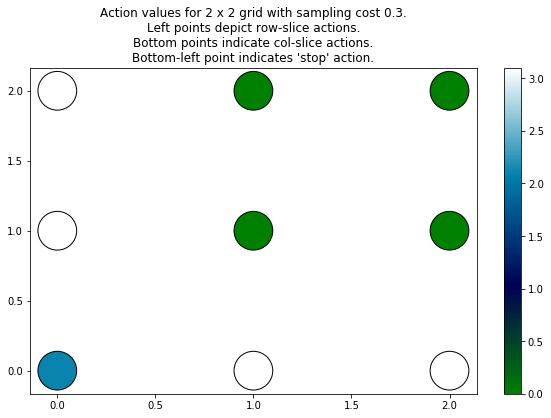

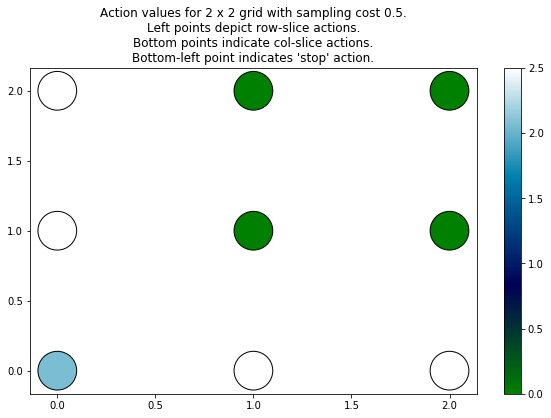

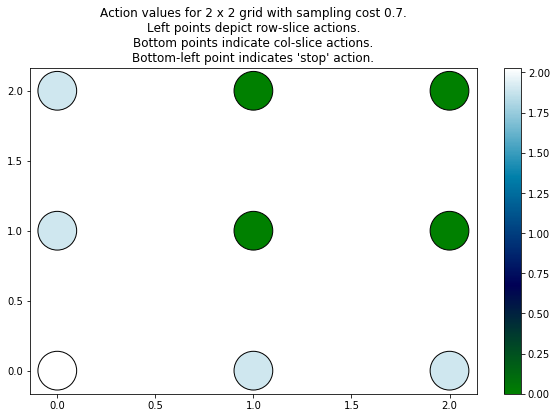

In [46]:
plot_init_slice_values(0.3,2)
plot_init_slice_values(0.5,2)
plot_init_slice_values(0.7,2)

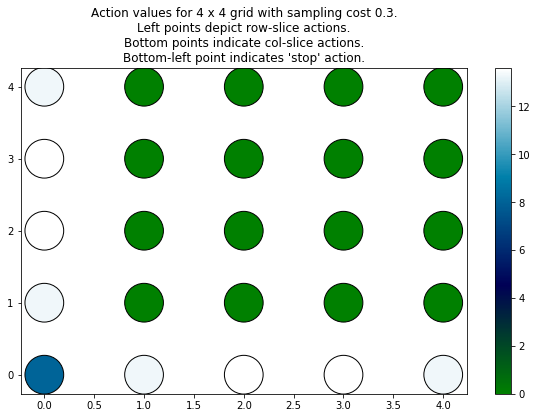

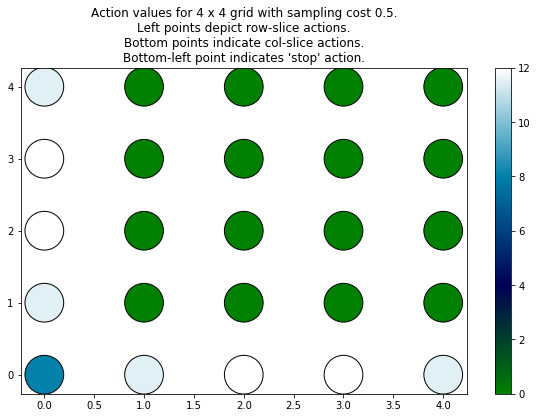

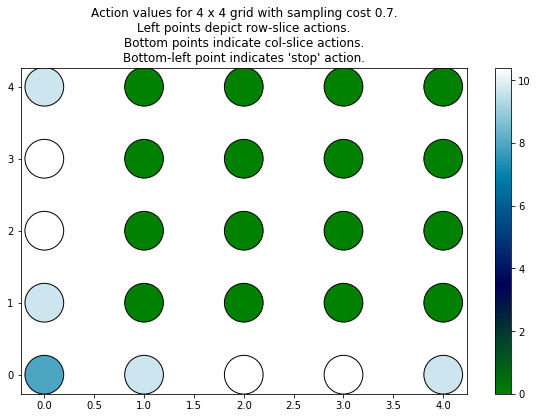

In [47]:
plot_init_slice_values(0.3,4)
plot_init_slice_values(0.5,4)
plot_init_slice_values(0.7,4)

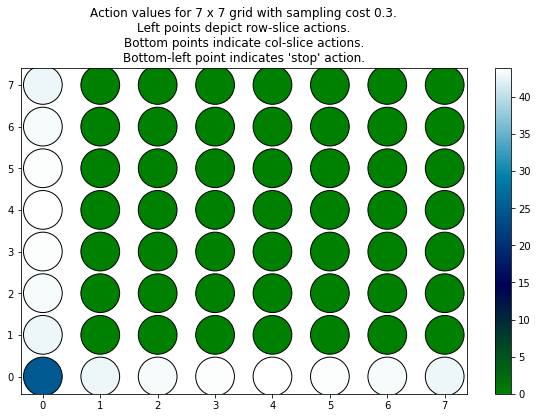

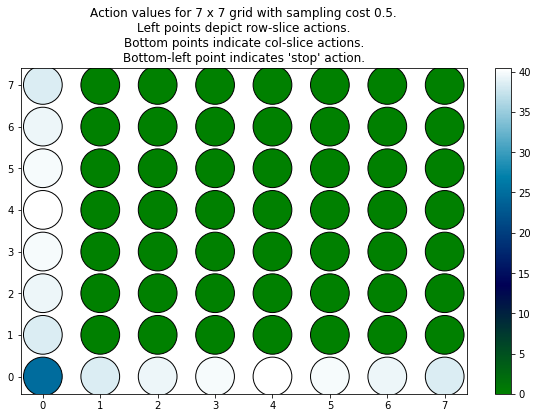

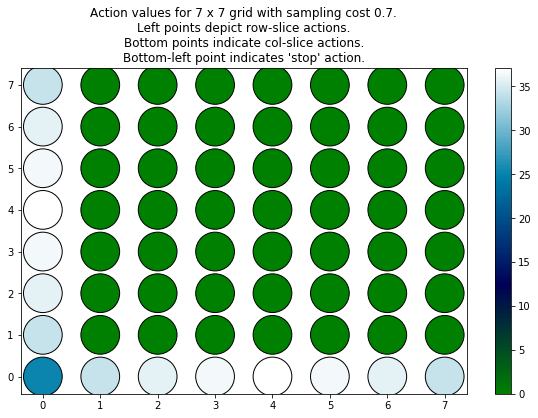

In [48]:
plot_init_slice_values(0.3,7)
plot_init_slice_values(0.5,7)
plot_init_slice_values(0.7,7)

## Brief Discussion

The values of row- and column- actions look reasonable (highest value for sampling at middle points; the value of column-actions looks equal to corresponding and row-actions, the dependence on cost is in the right direction for the 2 x 2 grid.

Followup experiments should be done to simulate the full policy, and compare it to reasonable heuristics.  The computation also look a long time.  We should revisit the idea about developing this theory for GMRFs over a sparse graph.

## Final Thoughts

Can we extend this to searching for the **maximum** value $X_v$?  Or just, searching for a single node $v$ for which $X_v$ exceeds some threshold $\alpha$?  The decomposition would have to account for the probability that each sub-region contains a large value, but maybe the conditional-independence makes this feasible...